# AutoEncoders

We have discussed using PCA for reducing the dimensionality of a dataset.  We can do something similar with AutoEncoders.  AutoEncoders are useful for:

* Finding a reduced representation of some data
* Removing noise, by training on noisy input data
* "Learning" features of events without labels

In this notebook we'll focus on using AutoEncoders to remove noise, but extending these examples to other types of AutoEncoders will hopefully be straightforward!

In [3]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

import time
import numpy as np

device="cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    device="cuda:0"
print(device)    

ImportError: cannot import name 'container_abcs' from 'torch._six' (/Users/ngokhang2000/opt/anaconda3/lib/python3.7/site-packages/torch/_six.py)

## Denoising 1D trends

Let's revisit an example that we used earlier in the course, where we want to learn the `sin` function:

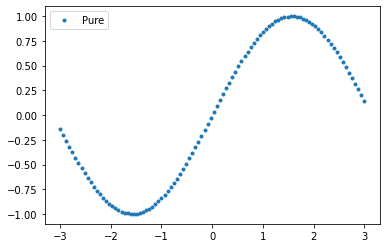

In [140]:
torch.manual_seed(123)
x_train = torch.linspace(-3,3,100)
y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), '.', label='Pure')
plt.legend();

Like before, we'll add some noise to the sin wave, and train on that:

In [141]:
def noisify(y,noise_variance=0.2):
    return y+(noise_variance**0.5)*torch.randn(len(y),)

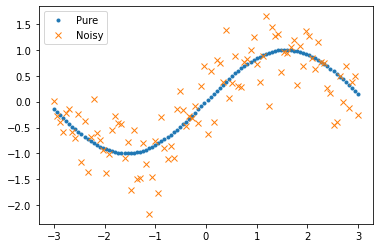

In [142]:
plt.plot(x_train.numpy(), y_train.numpy(), '.', label='Pure')
plt.plot(x_train.numpy(),noisify(y_train,0.2).numpy(),'x',label="Noisy")
plt.legend();

Now let's create a dataset of noisy `sin` curves for training.  We'll just be passing in `y` values in this case, and we'll need to keep track of what the "pure" data look like during training:

In [143]:
train=torch.tensor([list(noisify(y_train)) for i in range(1000)],dtype=torch.float)
trues=torch.tensor([list(        y_train ) for i in range(1000)],dtype=torch.float)

Now we define our model architecture.  

* `n` = number of inputs
* `d` = number of units in the hidden layer.  If the autoencoder is undercomplete, then `d` should be less than `n`.

In [144]:
class AutoEncoder(nn.Module):
    def __init__(self,n,d):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, n),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Initialize the network.  We're passing in as inputs all the points in the curve, and we're reducing down to just 3 dimensions in the hidden layer:

In [145]:
net=AutoEncoder(len(y_train),3)

We'll use mean-square-error as our loss function.  We could also use Binary-Cross-Entropy, but then we'd need to be a bit more careful about normalizing our inputs/outputs.

In [146]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

Now run the training!

In [147]:
torch.manual_seed(123)
losses_train = []
for epoch in range(200):
    start_time = time.time()
    # Calculate the loss on the training sample.
    net.train() # configure the model for training
    pred = net(train)
    loss = loss_fn(pred, trues)
    # Update the parameters.
    optimizer.zero_grad()  # reset the gradients
    loss.backward()        # recalculate gradients
    optimizer.step()       # step forward based on gradients
    # Save the training loss after each epoch.
    losses_train.append(loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e" % (epoch, elapsed_time, loss.data))    

Completed epoch  0 in  0.0s, Train loss=6.7e-01
Completed epoch  1 in  0.0s, Train loss=6.4e-01
Completed epoch  2 in  0.0s, Train loss=6.1e-01
Completed epoch  3 in  0.0s, Train loss=6.1e-01
Completed epoch  4 in  0.0s, Train loss=6.2e-01
Completed epoch  5 in  0.0s, Train loss=6.1e-01
Completed epoch  6 in  0.0s, Train loss=5.9e-01
Completed epoch  7 in  0.0s, Train loss=5.7e-01
Completed epoch  8 in  0.0s, Train loss=5.5e-01
Completed epoch  9 in  0.0s, Train loss=5.3e-01
Completed epoch 10 in  0.0s, Train loss=5.2e-01
Completed epoch 11 in  0.0s, Train loss=5.0e-01
Completed epoch 12 in  0.0s, Train loss=4.7e-01
Completed epoch 13 in  0.0s, Train loss=4.5e-01
Completed epoch 14 in  0.0s, Train loss=4.3e-01
Completed epoch 15 in  0.0s, Train loss=4.1e-01
Completed epoch 16 in  0.0s, Train loss=3.9e-01
Completed epoch 17 in  0.0s, Train loss=3.6e-01
Completed epoch 18 in  0.0s, Train loss=3.4e-01
Completed epoch 19 in  0.0s, Train loss=3.2e-01
Completed epoch 20 in  0.0s, Train loss=

That was quite fast!  Let's check the training loss.

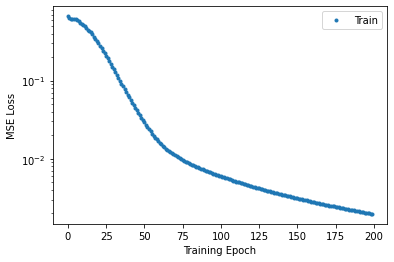

In [148]:
plt.plot(losses_train, '.', label='Train')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log');

Let's see how it does for a random new noisy curve:

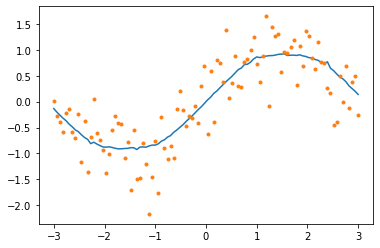

In [149]:
test=torch.tensor(list(noisify(y_train)))
net.eval()
denoised=net(test).detach().numpy()
plt.plot(x_train,denoised)
plt.plot(x_train,test,'.')

We can even ratchet up the noise and see that it still works reasonably well!

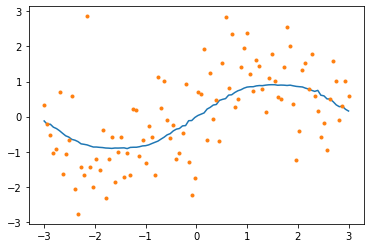

In [150]:
test=torch.tensor(list(noisify(y_train,0.9)))
net.eval()
denoised=net(test).detach().numpy()
plt.plot(x_train,denoised)
plt.plot(x_train,test,'.')

Can we do something crazier, like make the `sin` function into a `cos` function?

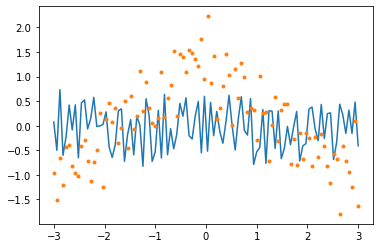

In [151]:
y_train_cos = torch.cos(x_train)
test_cos=torch.tensor(list(noisify(y_train_cos,0.2)))
net.eval()
denoised_cos=net(test_cos).detach().numpy()
plt.plot(x_train,denoised_cos)
plt.plot(x_train,test_cos,'.')

No we can't.  There are going to be limits to what we can do with this.

**Exercises**: play around with the hyperparameters of this tool.  How many dimensions do we really need?  How much noise can we add in?  Should we run for more/fewer epochs?

## Denoising images

Let's try to remove noise from images instead.  We'll use the MNIST dataset for this, since it's quite popular and easy to use.

In [ ]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

Now let's make the Autoencoder module, similar to how we did it before.  We'll use some slightly conventions here, but the core features are very similar to what we did above.

In [4]:
class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        

    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)
        
        return decoded

Now we create an instance of the network, get the data into shape, and get ready to train.

In [153]:
# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32

torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


Now train the model!

In [155]:
for epoch in range(num_epochs):
    start_time = time.time()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        loss = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e" % (epoch, elapsed_time, loss.data))    

Completed epoch  0 in  3.1s, Train loss=4.8e-02
Completed epoch  1 in  3.2s, Train loss=3.2e-02
Completed epoch  2 in  3.4s, Train loss=2.4e-02
Completed epoch  3 in  3.3s, Train loss=2.1e-02
Completed epoch  4 in  3.3s, Train loss=1.7e-02


Look at some examples of images before/after filtering:

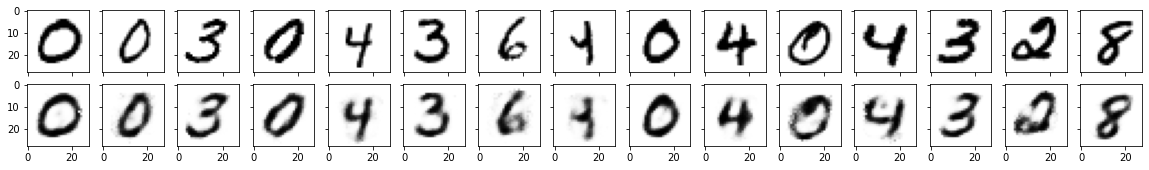

In [156]:
n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')


References:
* https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-signal-noise-removal-autoencoder-with-keras.md
* https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/L15_autoencoder/code/ae-simple-with-bce.ipynb